##  Prediction of Covid-19 spread using Time series with LSTM

###  Overview:

**World Health Organization (WHO) and medical authorities all over the world are busy in taking appropriate measures against COVID-19. It is important to do proper planning and the success is dependent on the arrangements that will be made in near future to stop the spread of this disease. This project by prediction of upcoming cases will help the authorities to plan accordingly, i.e. to arrange appropriate number of medical facilities.**

**Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) capable of learning order dependence in sequence prediction problem.**

<div>
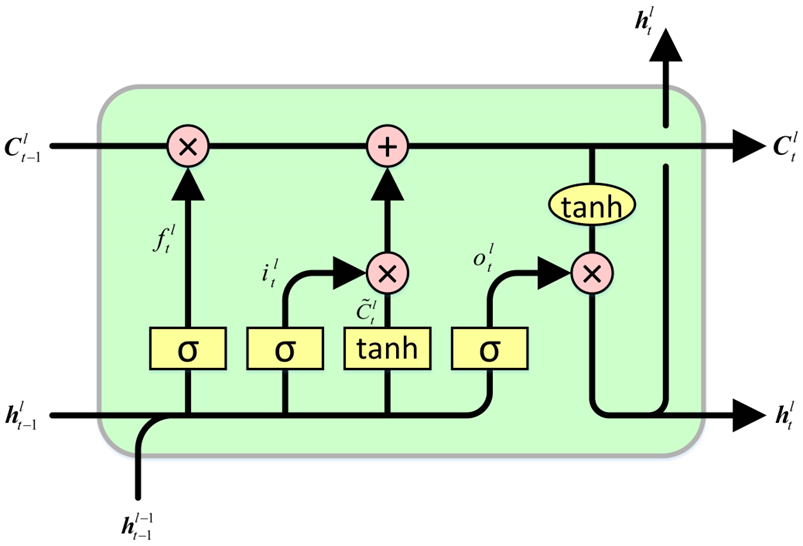
</div>

**Our task is to predict the following based on given data set**
* **Confirmed cases**
* **Recovered cases**
* **Death cases**
* **Mortality rate**

## Part-1: Data import and transformation

#### 1.1 Import libraries

In [278]:
# import required libraries
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

#### 1.2 Define functions

In [279]:
#get data from the github dataset link
def get_dataset(type):
    dataset = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{}_global.csv'.format(type))
    #filter data for country India
    dfSeries = dataset[dataset['Country/Region'].str.contains('India')]
    #drop columns which are not required
    dfSeries = dfSeries.drop(dfSeries.columns[[0, 1, 2, 3]], axis = 1)
    #take a transpose to convert columns(dates) into rows
    deSeries_T = dfSeries.T
    #rename the column with number of cases
    return deSeries_T.rename(columns={ deSeries_T.columns[0]: 'cases'})
    

In [280]:
#convert from dataset to pandas series
def convert_timeseries(df):
    df['date'] = df.index
    #format the date and convert into datetime datatype
    df['day'] = pandas.to_datetime(df['date'], format='%d/%m/%y', errors='ignore', infer_datetime_format=True) 
    #set the dates as the index for the series
    ts = df.set_index('day')["cases"]
    return ts

#### 1.3 Get Data

In [281]:
#get data for recovered, confirmed and death cases
df_recovered = get_dataset("recovered")
df_confirmed = get_dataset("confirmed")
df_deaths = get_dataset("deaths")

In [282]:
print("Confirmed cases: ")
df_confirmed.tail()

Confirmed cases: 


,cases
1/22/23,44683239
1/23/23,44683328
1/24/23,44683430
1/25/23,44683562
1/26/23,44682338


In [283]:
print("Recovered cases: ")
df_recovered.tail()

Recovered cases: 


,cases
1/22/23,0
1/23/23,0
1/24/23,0
1/25/23,0
1/26/23,0


In [284]:
print("Death cases: ")
df_deaths.tail()

Death cases: 


,cases
1/22/23,530735
1/23/23,530737
1/24/23,530737
1/25/23,530738
1/26/23,530738


#### 1.4 Format data

In [285]:
#get indivudual time series for recovered, confirmed and deaths
ts_recovered = convert_timeseries(df_recovered)
ts_confirmed = convert_timeseries(df_confirmed)
ts_deaths = convert_timeseries(df_deaths)
ts_confirmed.tail()

day
2023-01-22    44683239
2023-01-23    44683328
2023-01-24    44683430
2023-01-25    44683562
2023-01-26    44682338
Name: cases, dtype: int64

## Part-2: Data Analysis

#### 2.1 Import libraries

In [286]:
import statsmodels.api as sm
from statsmodels.tsa import seasonal

#### 2.2 Define functions

In [287]:
#define funtion to plot the time series
def plot_timeseries(ts, color, total, pos,label):
    plt.figure(figsize=(30,20))
    plt.subplot(total, 1, pos)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(ts, color=color)


In [288]:
#define funtion to perform Augmented Dickey-Fuller test to check stationarity of series
def adf_test(ts):
    adf_result = sm.tsa.stattools.adfuller(ts)
    print("Adf statistic: ", adf_result[0])
    print("p-value", adf_result[1])
    print("Critical values: ")
    for key, value in adf_result[4].items():
        print('\t{}: {}'.format(key, value))


In [289]:
#define funtion to plot the decomposed components of the series
def plot_decompose(ts, color,label):
    
    fig, axes = plt.subplots(4, len(ts), figsize=(30, 10))
    for i in range(0, len(ts)):
        decompose_ts = seasonal.seasonal_decompose(ts[i].to_list(), period=365, model='additive')
        axes[0, i].plot(decompose_ts.observed, color=color[i])
        axes[0, i].set_ylabel('Observed')
        axes[1, i].plot(decompose_ts.trend, color=color[i])
        axes[1, i].set_ylabel('Trend')
        axes[2, i].plot(decompose_ts.seasonal, color = color[i])
        axes[2, i].set_ylabel('Seasonal')
        axes[3, i].plot(decompose_ts.resid, color=color[i])
        axes[3, i].set_ylabel('Residual')
        axes[3, i].set_xlabel(label[i])
    fig.tight_layout()
    return decompose_ts

In [388]:
#define funtion to remove sudden the spkies from a series
def remove_spikes(ts, threshold):
    cnt = 0
    prev = 0
    for i, v in ts.items():
        if(cnt == 0):
            prev = ts[i]
            cnt+= 1
            continue
        if((ts[i] - prev) > threshold):
            ts[i] = prev
        prev = ts[i]
        cnt+= 1
    return ts

#define function to remove negative values
def remove_negative(ts):
    for i, v in ts.items():
        if(ts[i] < 0):
            ts[i] = 0
    return ts

#### 2.2 Analyse time series

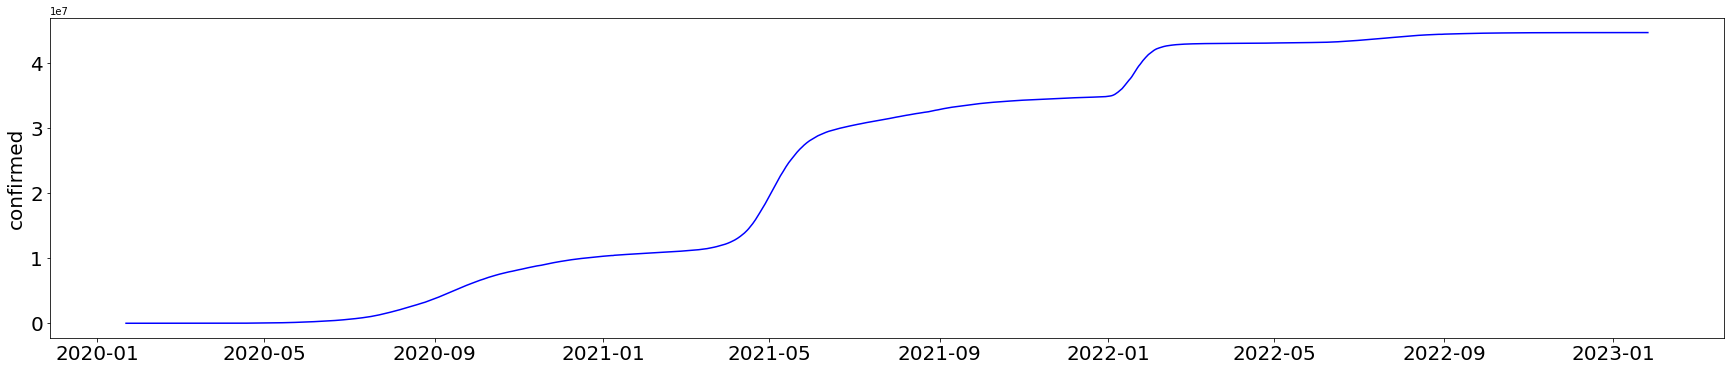

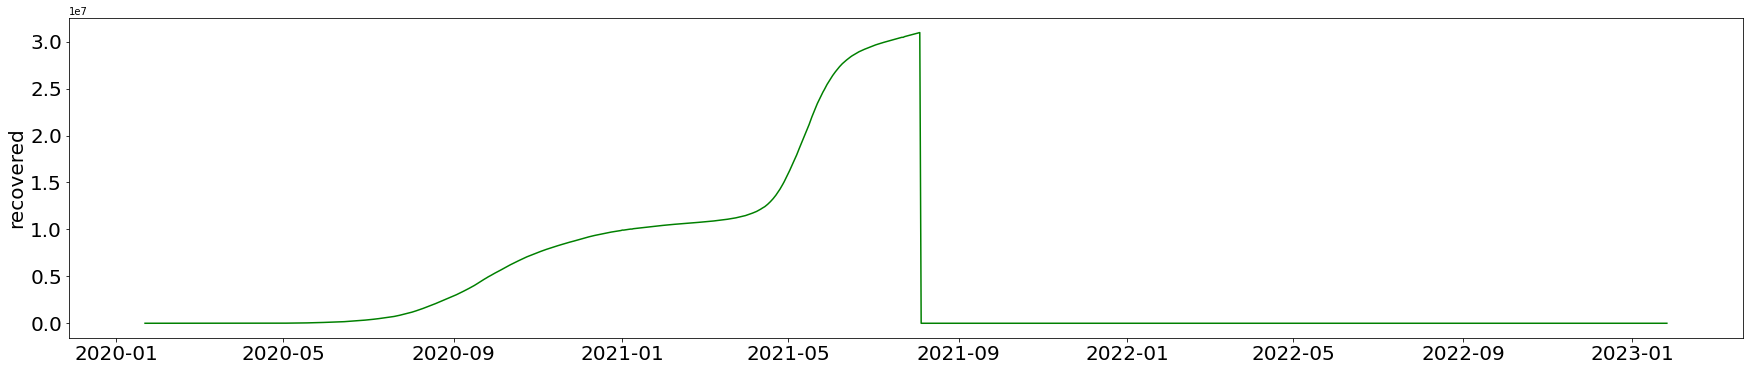

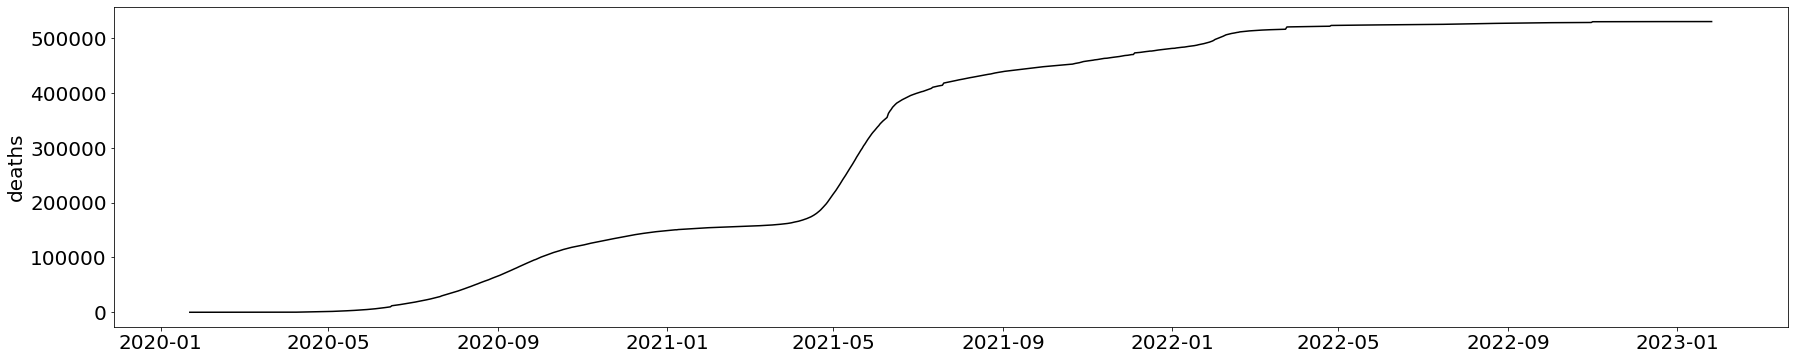

In [291]:
#plot all three time series
plot_timeseries(ts_confirmed, 'blue', 3, 1,"confirmed")
plot_timeseries(ts_recovered, 'green', 3, 2,"recovered")
plot_timeseries(ts_deaths, 'black', 3, 3,"deaths")

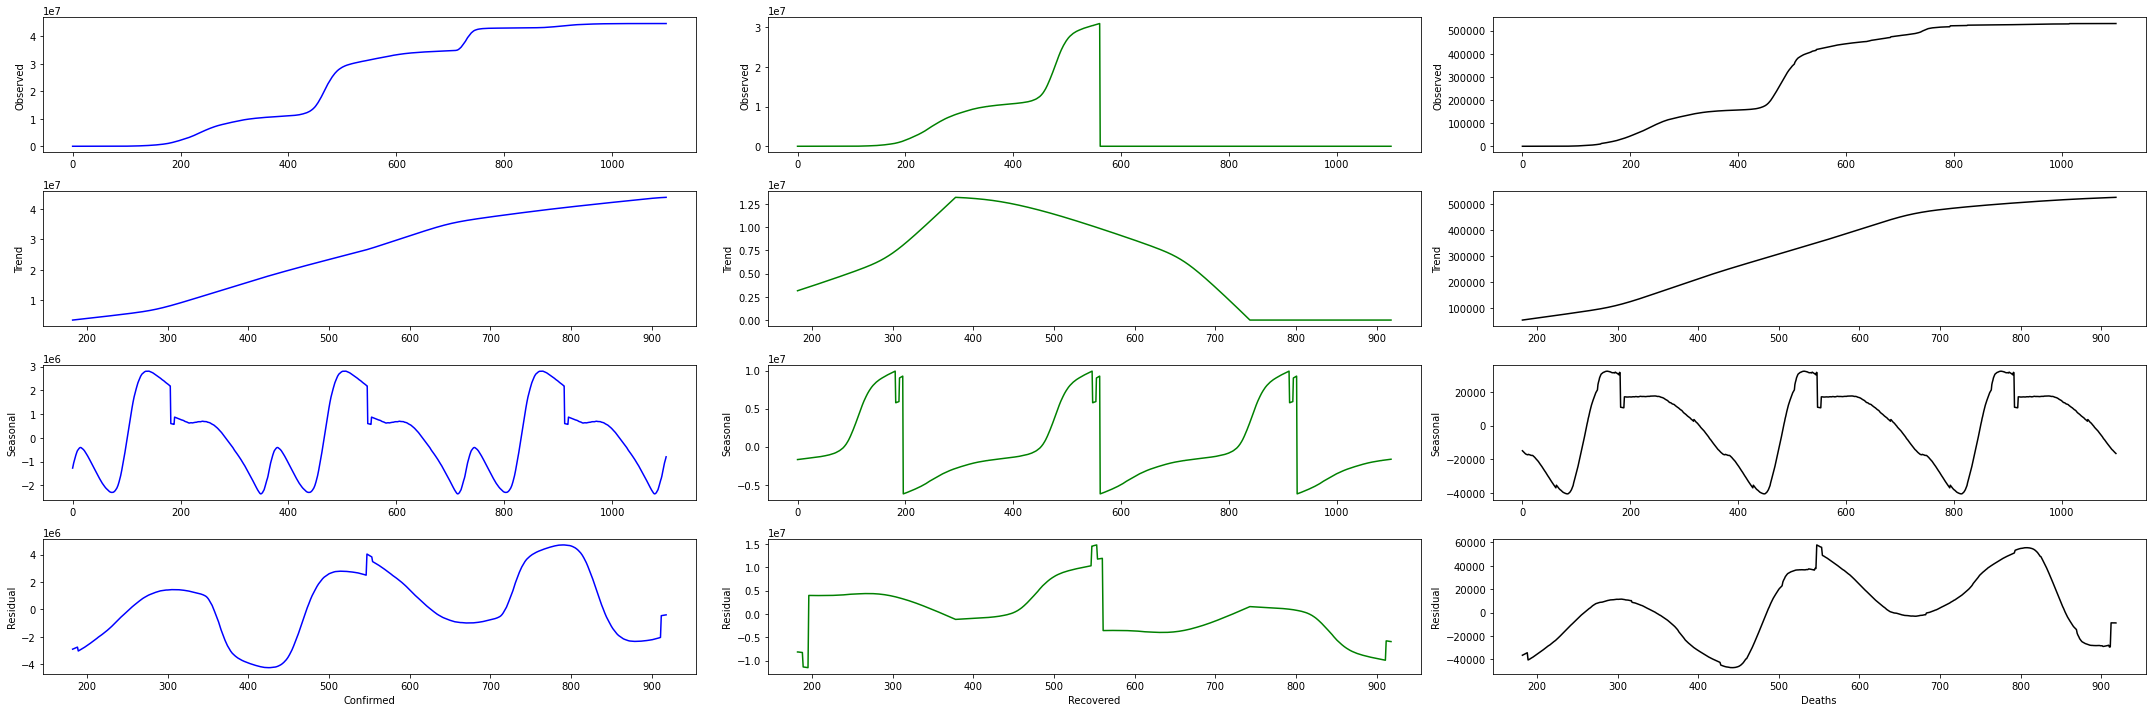

In [292]:
#plotting the decomposed view of series
decompose_ts = plot_decompose([ts_confirmed, ts_recovered, ts_deaths], ['blue', 'green', 'black'],["Confirmed","Recovered", "Deaths"])

<span style="color:teal">**- We can see that there is an upward trend, suggesting that the series is non-stationary**</span>

<span style="color:teal">**- We can see that there are 3 major waves of covid so far in India, however they did not happen in the same months, so there is a cyclic component but not seasonal component**</span>

In [293]:
print("ADF test results with no differencing")
adf_test(ts_confirmed)
#with no differencing, we can see that the p-value is > 0.05 so not stationary

ADF test results with no differencing
Adf statistic:  -1.19757669873497
p-value 0.6746372852285737
Critical values: 
	1%: -3.4364306491488814
	5%: -2.8642248442477976
	10%: -2.5681995044075987


ADF test results with 1 differencing
Adf statistic:  -3.0825738363399973
p-value 0.02786997023447155
Critical values: 
	1%: -3.4364306491488814
	5%: -2.8642248442477976
	10%: -2.5681995044075987


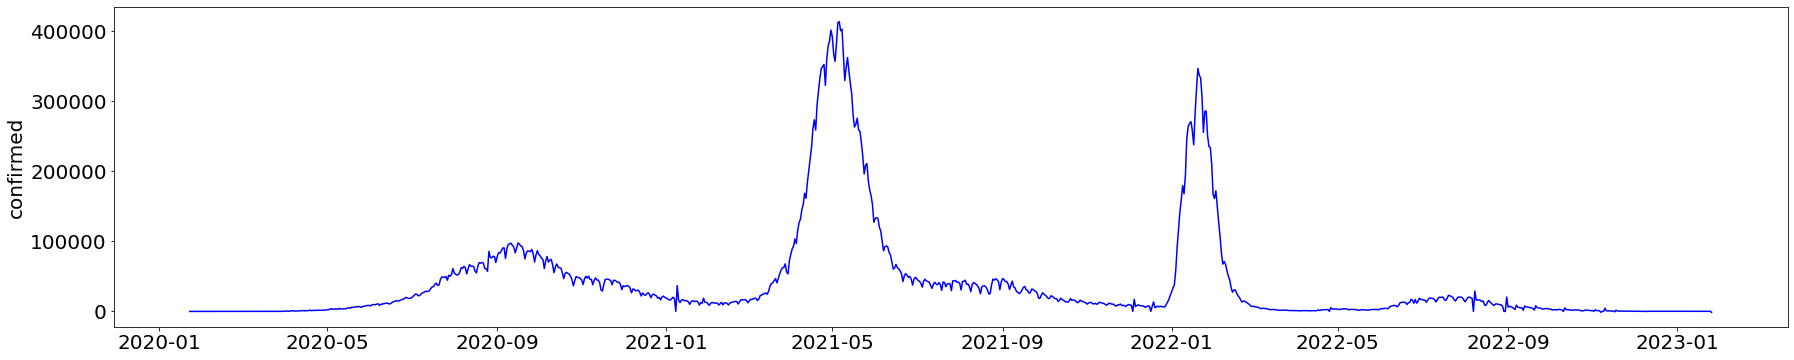

In [294]:
print("ADF test results with 1 differencing")
ts_confirmed_diff1 = ts_confirmed.diff().dropna()
adf_test(ts_confirmed_diff1)
#with 1 differencing, we can see that the p-value is < 0.05 so it is stationary but it is very close to 0.05
plot_timeseries(ts_confirmed_diff1, 'blue', 3, 1,"confirmed")

ADF test results with 2 differencing
Adf statistic:  -8.63680614166171
p-value 5.56235110653384e-14
Critical values: 
	1%: -3.436425000208065
	5%: -2.864222352544219
	10%: -2.5681981773275466


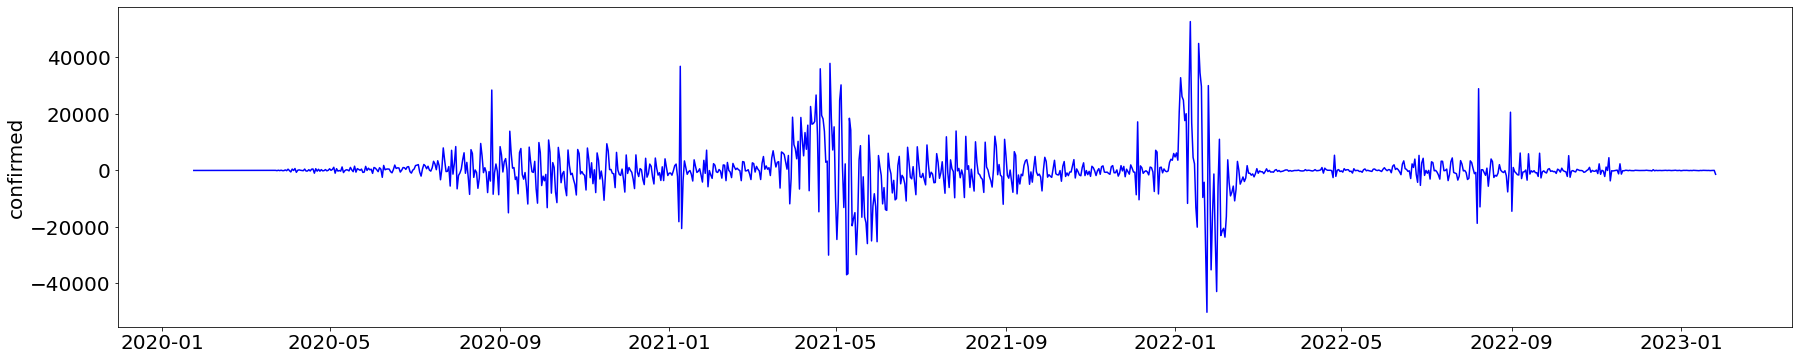

In [295]:
print("ADF test results with 2 differencing")
ts_confirmed_diff2 = ts_confirmed_diff1.diff().dropna()
adf_test(ts_confirmed_diff2)
#with 2 differencing, we can see that the p-value is < 0.05 so it is stationary
plot_timeseries(ts_confirmed_diff2, 'blue', 3, 1,"confirmed")

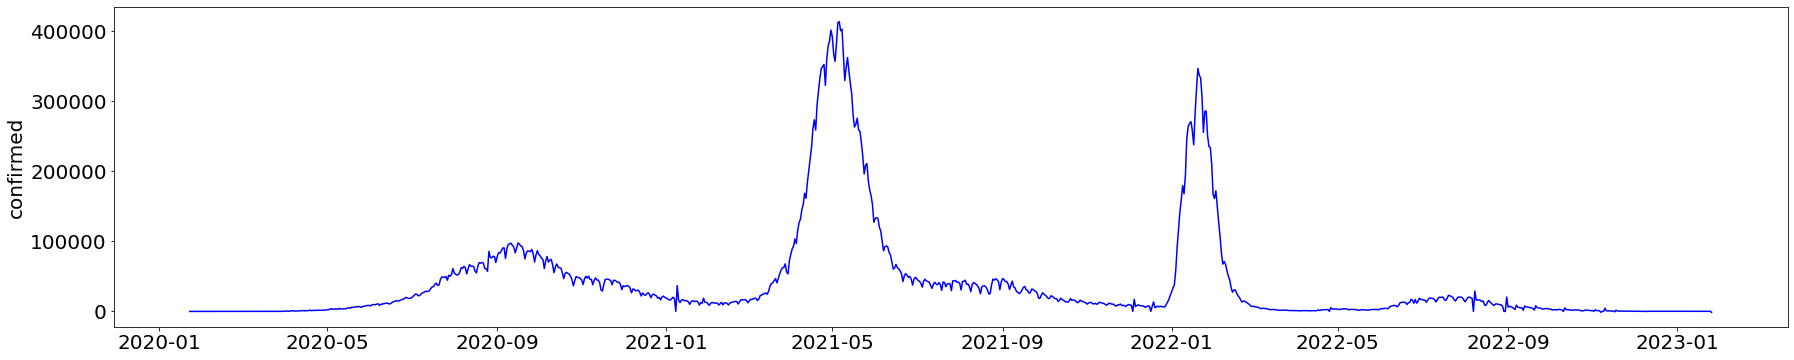

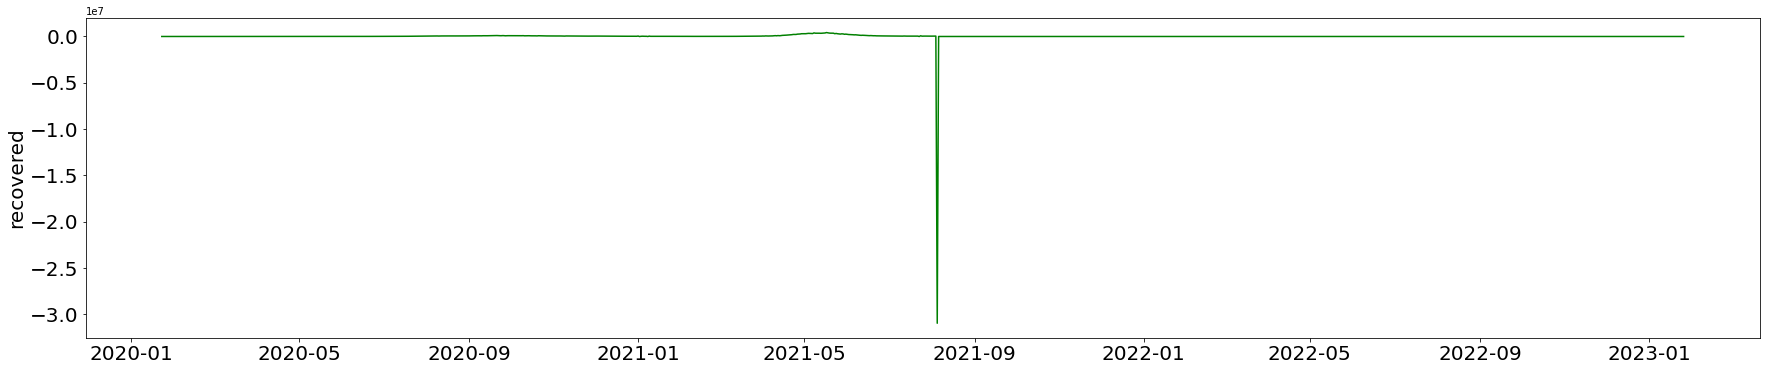

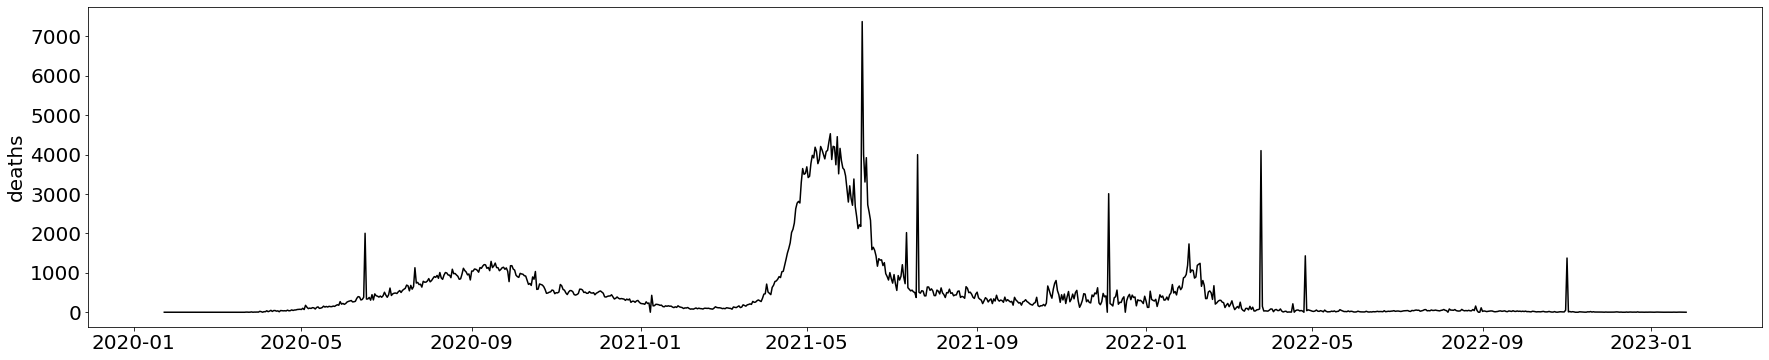

In [296]:
#plot all three series after applying 1st order differencing

ts_confirmed_diff1 = ts_confirmed.diff().dropna()
ts_recovered_diff1 = ts_recovered.diff().dropna() 
ts_deaths_diff1 = ts_deaths.diff().dropna() 

plot_timeseries(ts_confirmed_diff1, 'blue', 3, 1,"confirmed")
plot_timeseries(ts_recovered_diff1, 'green', 3, 2,"recovered")
plot_timeseries(ts_deaths_diff1, 'black', 3, 3,"deaths")

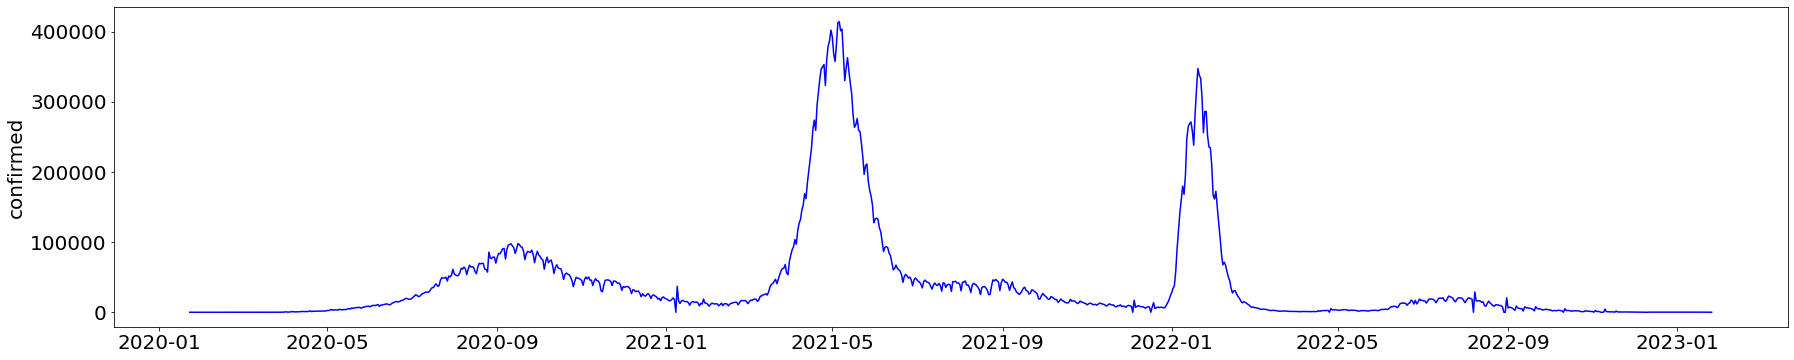

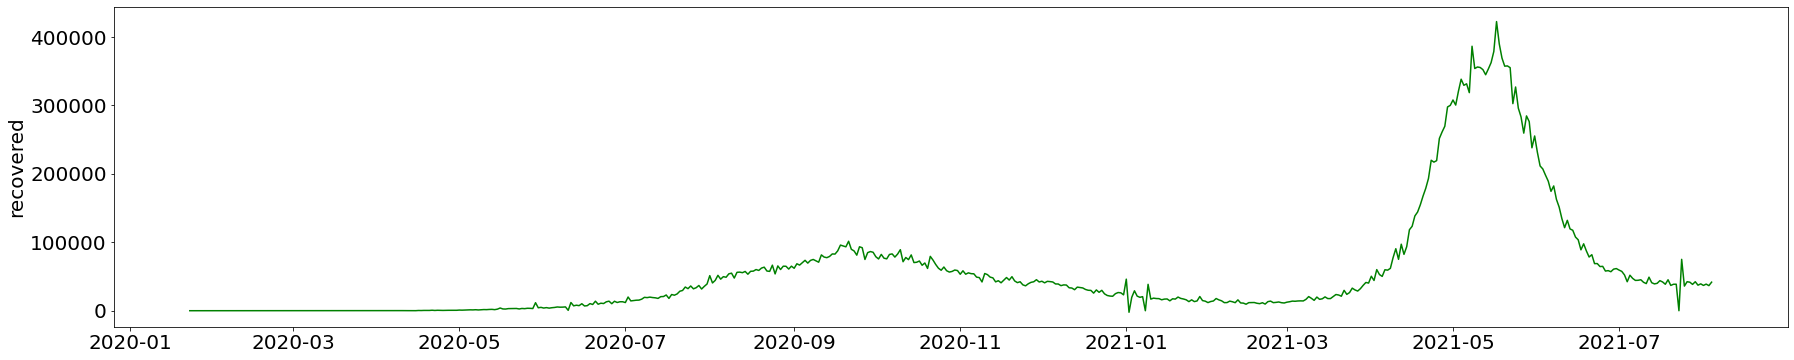

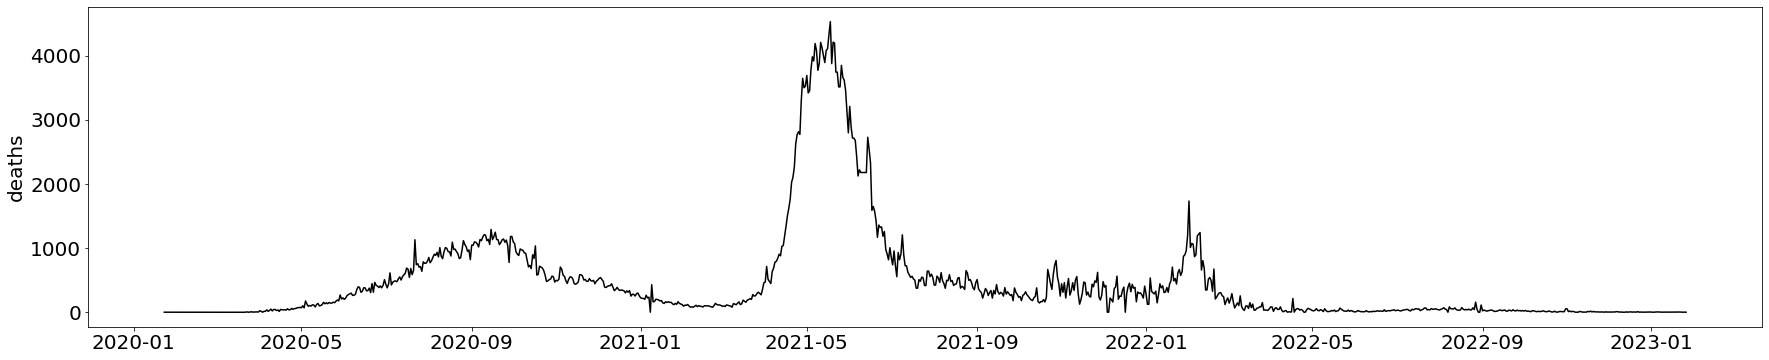

In [463]:
#cleaning data
ts_recovered_diff1 = ts_recovered[:"Aug-04-2021"].diff().dropna() #here we are dropping data after Aug-04-2021 because they have stopped updating recovered cases after that
ts_deaths_diff1 = remove_spikes(ts_deaths.diff().dropna(), 550) #here we are removing the spikes in the deaths data
ts_confirmed_diff1 = remove_negative(ts_confirmed_diff1)

plot_timeseries(ts_confirmed_diff1, 'blue', 3, 1,"confirmed")
plot_timeseries(ts_recovered_diff1, 'green', 3, 2,"recovered")
plot_timeseries(ts_deaths_diff1, 'black', 3, 3,"deaths")

<span style="color:teal">**We will be considering above 3 series to build our models**</span>

#### 2.3. Derive Mortality Rate

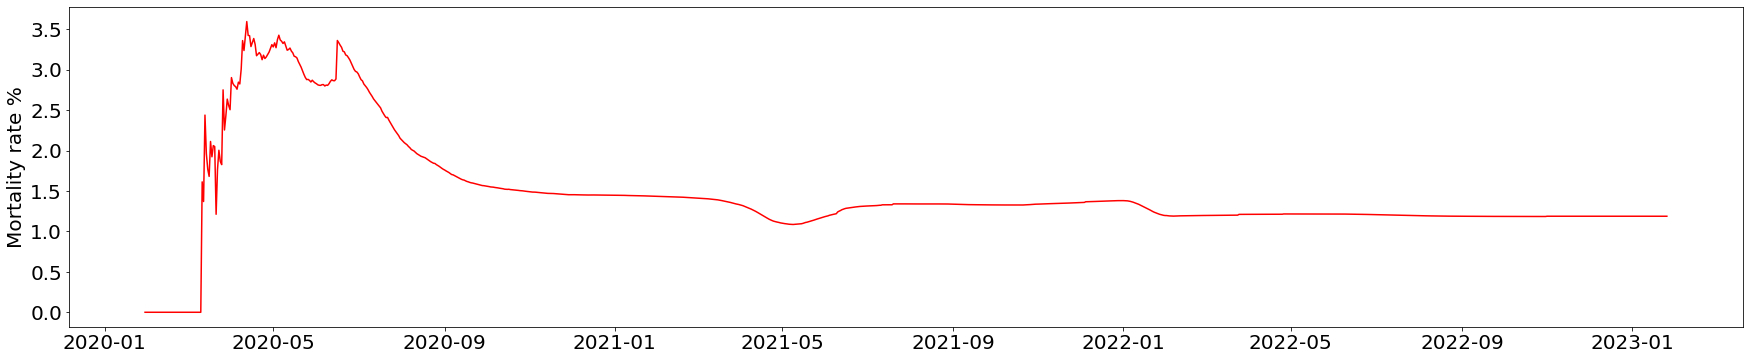

In [464]:
# Mortality rate = (Number of Deaths/ Number of Confirmed cases) * 100
tsMR = (ts_deaths/ts_confirmed)*100
plot_timeseries(tsMR, 'red', 3, 1,"Mortality rate %")

<span style="color:teal">**Notice how mortality rate was high in the earlier days and later it dropped down**</span>

## PART-3 : Benchmarking with ARIMA

#### 3.1 Import libraries

In [466]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
import math
import statistics

#### 3.2 Define functions

In [467]:
#define function to plot acf and pacf graphs
def plot_acf_pacf(ts):
    plt.figure(figsize=(30,10))
    plt.subplot(211)
    plot_acf(ts,lags=100, ax= plt.gca());
    plt.subplot(212)
    plot_pacf(ts,lags=100, method='ywm', ax=plt.gca());
    

In [468]:
def train_test(ts,per):
    count = round(len(ts) * per)
    return ts[:count], ts[count:]

def evaluate_metrics(tsOriginal, tsPredict, suffix,metrics):
    r2s= r2_score(tsOriginal, tsPredict) #results_ARIMA.fittedvalues)
    metrics["R2Score"] = r2s
    print(suffix+ " R2-score: ", r2s)
    RSS =tsPredict.values-tsOriginal.values
    meanOrig = statistics.mean(tsOriginal.values)
    RMSE = math.sqrt((sum(RSS**2)/len(RSS)))
    metrics["RMSE"] = RMSE
    print(suffix+ ' NRMSE: %.4f'% (RMSE/meanOrig))
    metrics["NRMSE"] = RMSE/meanOrig
    return metrics
    
    
#define function to build ARIMA model
def build_ARIMA(tsTrain, p, d, q, metrics):
    model = ARIMA(tsTrain, order=(p,d,q), freq=tsTrain.index.inferred_freq)  
    results_ARIMA = model.fit()  
    evaluate_metrics(tsTrain,results_ARIMA.fittedvalues,"Train", metrics)
    return results_ARIMA

def plot_residuals(residuals):
    fig, ax = plt.subplots(1,2, figsize = (10, 3))
    #plt.figure(figsize=(30,10))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    
def predict_results(results_ARIMA,tsTest,metrics):        
    result_append = results_ARIMA.append(tsTest,freq=tsTest.index.inferred_freq)
    fc = result_append.forecast(tsTest.shape[0], alpha=0.05)  # 95% conf
    predict = result_append.predict(start=len(tsTrain), end=len(tsTrain)+len(tsTest)-1)
    fc_series = pandas.Series(predict, index=tsTest.index)
    evaluate_metrics(tsTest,fc_series,"Test", metrics)
    return fc_series

def plot_results(tsTrain, tsTest, tsPredict):
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(tsTrain, label='training')
    plt.plot(tsTest, label='actual')
    plt.plot(tsPredict, label='predicted')    
    plt.show()
    

#### 3.3 Build ARIMA model

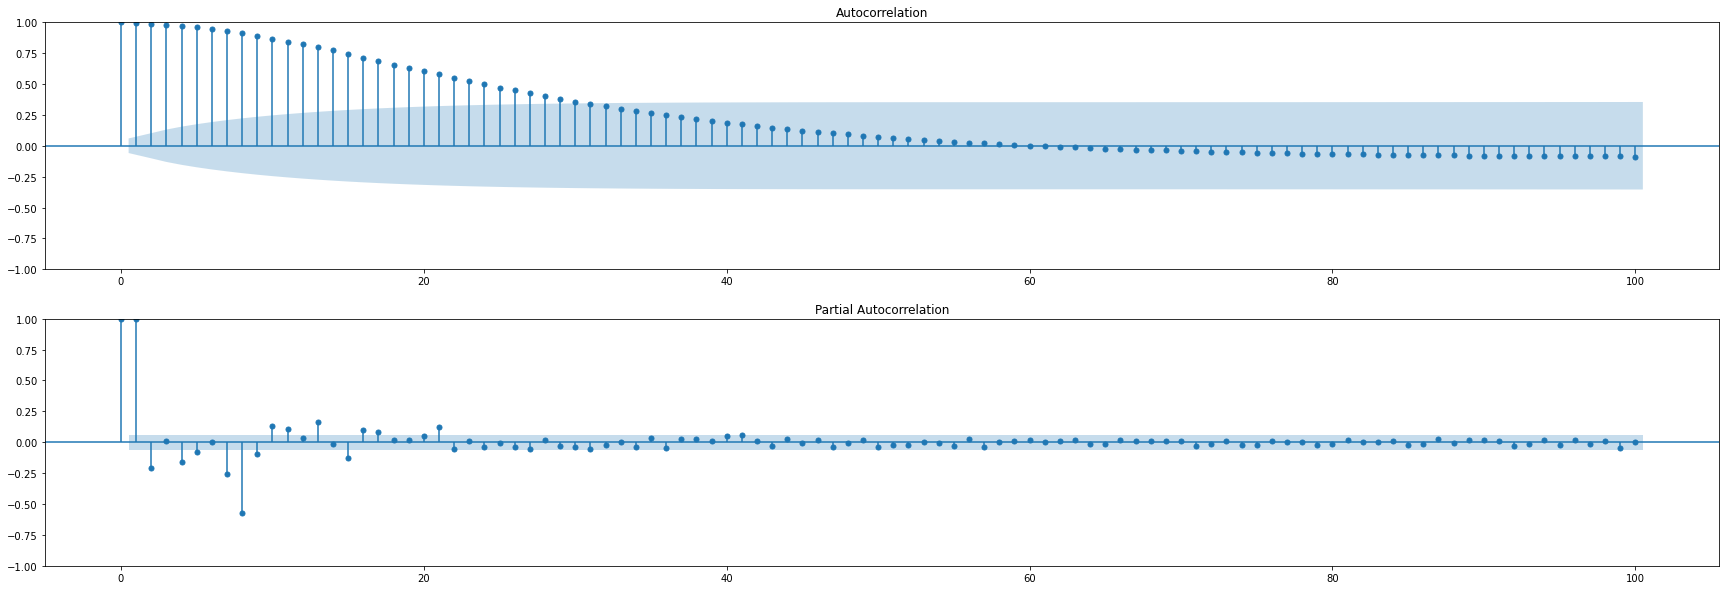

In [469]:
plot_acf_pacf(ts_confirmed_diff1)

C:\Users\Rashmi\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Rashmi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Train R2-score:  0.9960038833407076
Train NRMSE: 0.0955
Test R2-score:  0.9877236904668731
Test NRMSE: 0.2842


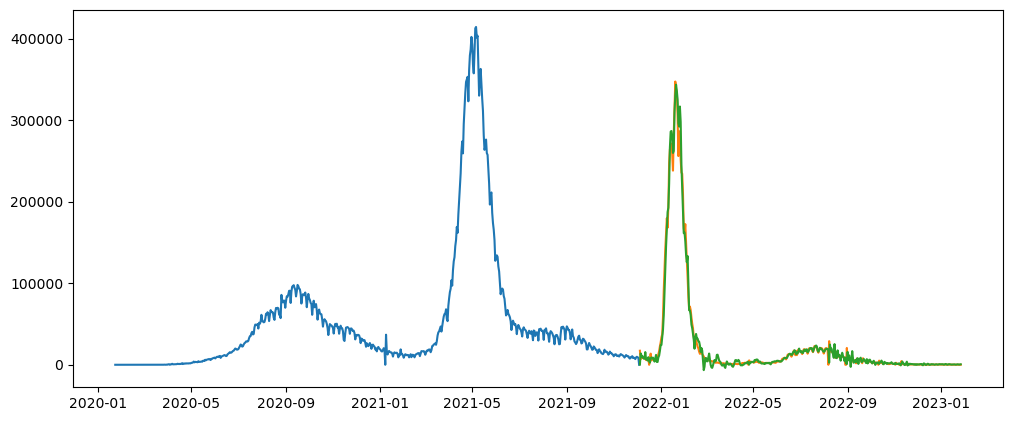

In [470]:
metricsARIMATrain = {"Model": "ARIMA", "Data": "Train"}
metricsARIMATest = {"Model": "ARIMA", "Data": "Test"}

tsTrain, tsTest = train_test(ts_confirmed_diff1, 0.62)
results_ARIMA = build_ARIMA(tsTrain, 2,0,24,metricsARIMATrain)

tsPredict = predict_results(results_ARIMA,tsTest,metricsARIMATest)
plot_results(tsTrain,tsTest,tsPredict)

#### 3.4. Evaluating results

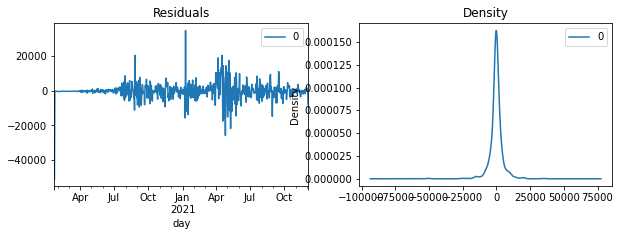

In [471]:
#plotting residuals
plot_residuals(pandas.DataFrame(results_ARIMA.resid))

<span style="color:teal">**The residual errors seem fine with near zero mean and uniform variance**</span>

In [472]:
#printing the summary of ARIMA model
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  cases   No. Observations:                  682
Model:                ARIMA(2, 0, 24)   Log Likelihood               -6747.445
Date:                Sat, 28 Jan 2023   AIC                          13550.889
Time:                        11:07:31   BIC                          13677.590
Sample:                    01-23-2020   HQIC                         13599.925
                         - 12-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.077e+04    6.9e+04      0.736      0.462   -8.45e+04    1.86e+05
ar.L1          1.0457      2.152      0.486      0.627      -3.172       5.263
ar.L2         -0.0633      2.114     -0.030      0.976      -4.206       4.080
ma.L1         -0.2598      2.147     -0.121      0.904      -4.467       3.947
ma.L2          0.0338      0.418      0.081      0.935      -0.786       0.853
ma.L3          0.1009      0.067      1.502      0.133      -0.031       0.232
ma.L4          0.0184      0.223      0.082      0.934      -0.419       0.456
ma.L5          0.0646      0.078      0.833      0.405      -0.088       0.217
ma.L6          0.2092      0.151      1.381      0.167      -0.088       0.506
ma.L7          0.5576      0.450      1.240      0.215      -0.324       1.439
ma.L8          0.0379      1.214      0.031      0.975      -2.341       2.417
ma.L9         -0.0194      0.174     -0.111      0.911      -0.361       0.322
ma.L10        -0.0120      0.077     -0.156      0.876      -0.162       0.138
ma.L11         0.0829      0.064      1.292      0.196      -0.043       0.209
ma.L12        -0.0230      0.169     -0.136      0.892      -0.354       0.308
ma.L13         0.2872      0.061      4.735      0.000       0.168       0.406
ma.L14         0.4372      0.609      0.718      0.473      -0.756       1.631
ma.L15         0.0042      0.974      0.004      0.997      -1.905       1.914
ma.L16         0.0101      0.090      0.113      0.910      -0.166       0.186
ma.L17         0.0583      0.073      0.803      0.422      -0.084       0.200
ma.L18         0.0907      0.124      0.733      0.463      -0.152       0.333
ma.L19         0.0083      0.197      0.042      0.966      -0.377       0.394
ma.L20         0.1615      0.059      2.759      0.006       0.047       0.276
ma.L21         0.3515      0.340      1.035      0.301      -0.314       1.017
ma.L22        -0.0508      0.772     -0.066      0.948      -1.564       1.463
ma.L23        -0.0884      0.102     -0.863      0.388      -0.289       0.112
ma.L24         0.0370      0.179      0.207      0.836      -0.314       0.388
sigma2      3.455e+07        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3342.22
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               4.50   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.44e+30. Standard errors may be unstable.
"""

## Part-4: Building LSTM Model

#### 4.1. Import libraires

In [473]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### 4.2. Define functions

In [474]:
def format_data(ds, lag):
    arrX, arrY = [], []
    for i in range(len(ds)-lag-1):
        arrX.append(ds[i:(i+lag), 0])
        arrY.append(ds[i + lag, 0])
    arrX = np.array(arrX)
    arrY = np.array(arrY)
    arrX = np.reshape(arrX, (arrX.shape[0], 1, lag))
    return arrX, arrY

In [475]:
def rearrange_data(predicted, base, start, stop):
    ds = base.iloc[start:stop].copy(deep =True)
    for i in range(0, len(ds)):
        ds.iloc[i:i+1] = predicted[i]
    return ds

In [476]:
def plot_result(tsActual, tsTrainPred, tsTestPred, label):
    plt.figure(figsize=(30,10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(label, fontsize=20)
    plt.plot(tsActual, color = "blue")
    plt.plot(tsTrainPred, color = "green")
    plt.plot(tsTestPred, color = "orange")
    plt.legend(["Actual", "Train", "Test"], fontsize= 20)

In [477]:
def prepare_data(ts, lag, split):
    tf.random.set_seed(42)
    dataset = ts.dropna().values
    dataset = dataset.astype('float32').reshape(-1,1)
    
    # split into train and test sets
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    return train, test

In [478]:
def get_model(trainX, trainY, units, epochs, batchsize, lag):
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(units = units, input_shape=(1, lag),name= "LSTM_layer"))
    model.add(Dense(units = 1, name = "Dense_layer"))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batchsize, verbose=0)
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    return model

In [479]:
def get_predictions(model,dataX, scaler):
    # make predictions
    yPredict = model.predict(dataX)
    # invert normalisation
    yPredict = scaler.inverse_transform(yPredict)
    return yPredict

def evaluate_results(actual,predicted, suffix, metrics):
    # calculate root mean squared error
    r2s= r2_score(actual[0], predicted[:,0])
    print(suffix + " R2-score: ", r2s)
    metrics["R2Score"] = r2s
    RMSE = np.sqrt(mean_squared_error(actual[0], predicted[:,0]))
    metrics["RMSE"] = RMSE
    print(suffix + ' Score: %.2f RMSE' % (RMSE))
    Score = RMSE/np.mean(actual[0])
    print(suffix + ' Score: %.2f NRMSE' % (Score))
    metrics["NRMSE"] = Score


In [480]:
def plot_metrics(ax, x, dfTrain, dfTest, metric):
    xpos = np.arange(len(x))  # the label locations
    width = 0.35  # the width of the bars
    ax.bar(xpos - width/2, dfTrain[metric], width, label = "Train")
    ax.bar(xpos + width/2, dfTest[metric], width, label = "Test")
    ax.set_ylabel(metric)
    #ax.set_title('Scores by group and gender')
    ax.set_xticks(xpos)
    ax.set_xticklabels(x, fontsize = 12)
    ax.legend()

#### 4.3. Build LSTM model

#### 4.3.1. Build model for confirmed cases

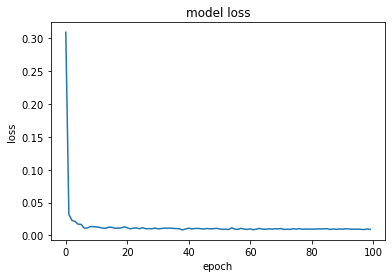

13/13 [==============================] - 0s 2ms/step
Train R2-score:  0.9921745212403561
Train Score: 6766.30 RMSE
Train Score: 0.13 NRMSE
Test R2-score:  0.9861456009381572
Test Score: 7406.46 RMSE
Test Score: 0.30 NRMSE


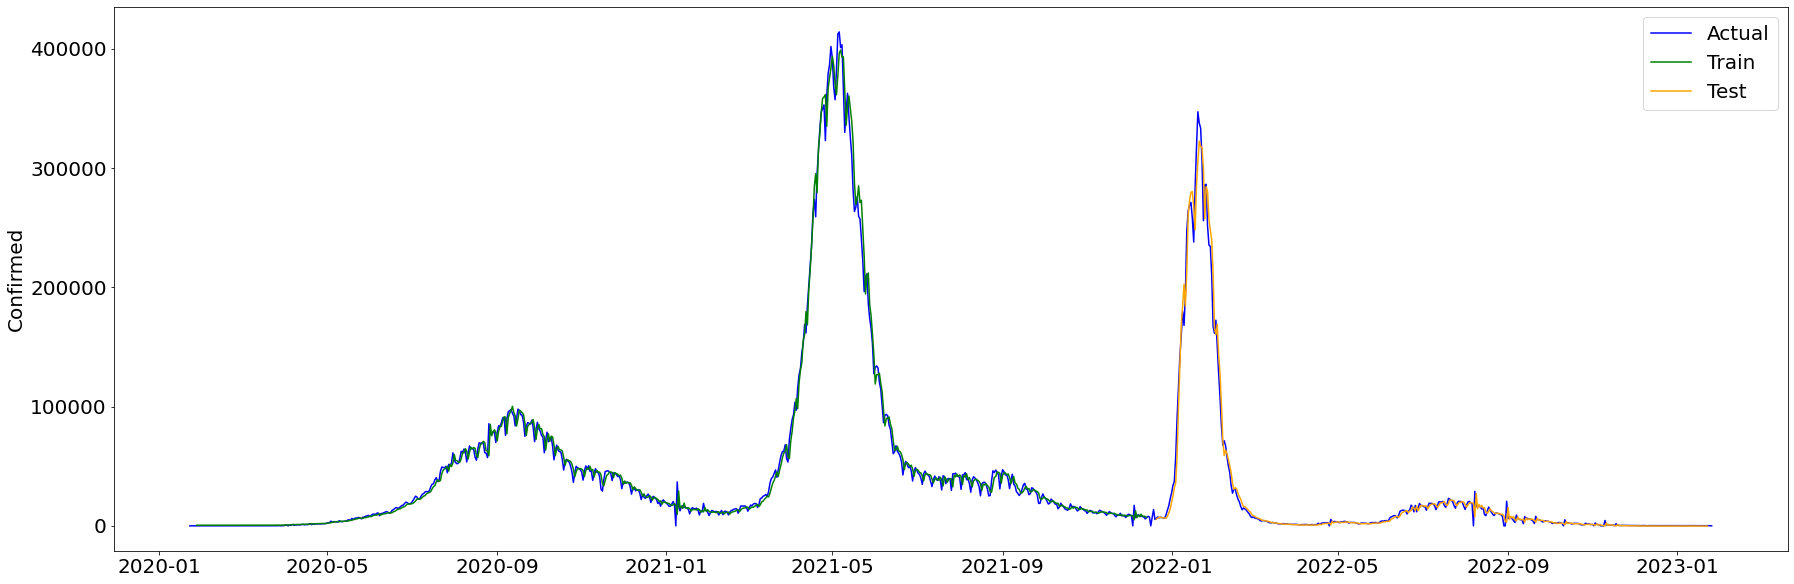

In [481]:
#choosing lookback period as 5
lag = 5

#split data into train and test
train, test = prepare_data(ts_confirmed_diff1, lag, 0.63)

#use separate scalers to scale the training and test data
scalerTrain = StandardScaler()
train = scalerTrain.fit_transform(train.reshape(-1,1))
scalerTest = StandardScaler()
test = scalerTest.fit_transform(test.reshape(-1,1))

#format the data in 5,1 shape 
trainX, trainY = format_data(train, lag)
testX, testY = format_data(test, lag)
metricsConfirmedTrain = {"Model": "LSTM-Confirmed", "Data": "Train"}
metricsConfirmedTest = {"Model": "LSTM-Confirmed", "Data": "Test"}

#build LSTM model
modelConfirmed = get_model(trainX, trainY, 25, 100,1, lag)

#predict values for training and test set separately
trainPredict = get_predictions(modelConfirmed, trainX, scalerTrain)
testPredict = get_predictions(modelConfirmed, testX, scalerTest)

#inverse the scale of predictions
trainY = scalerTrain.inverse_transform([trainY])
testY = scalerTest.inverse_transform([testY])

#calculate metrics for model evaluation
evaluate_results(trainY, trainPredict, "Train", metricsConfirmedTrain)
evaluate_results(testY, testPredict, "Test", metricsConfirmedTest)

#maps the predicted values with their dates
tsTrainPred_C = rearrange_data(trainPredict[:,0], ts_confirmed_diff1, lag, trainPredict[:,0].shape[0]+lag)
tsTestPred_C = rearrange_data(testPredict[:,0], ts_confirmed_diff1, trainPredict[:,0].shape[0]+lag+lag+1, trainPredict[:,0].shape[0]+testPredict[:,0].shape[0]+lag+lag-1)

#plot the result
plot_result(ts_confirmed_diff1,tsTrainPred_C,tsTestPred_C, "Confirmed")

#### 4.3.2. Build model for recovered cases

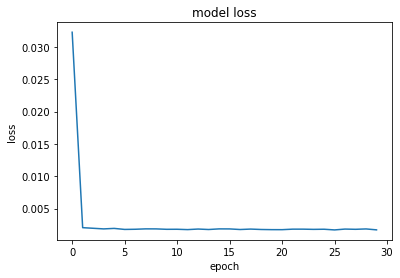

4/4 [==============================] - 0s 3ms/step
Train R2-score:  0.9706723279828098
Train Score: 4622.50 RMSE
Train Score: 0.17 NRMSE
Test R2-score:  0.9575442556309705
Test Score: 24609.63 RMSE
Test Score: 0.16 NRMSE


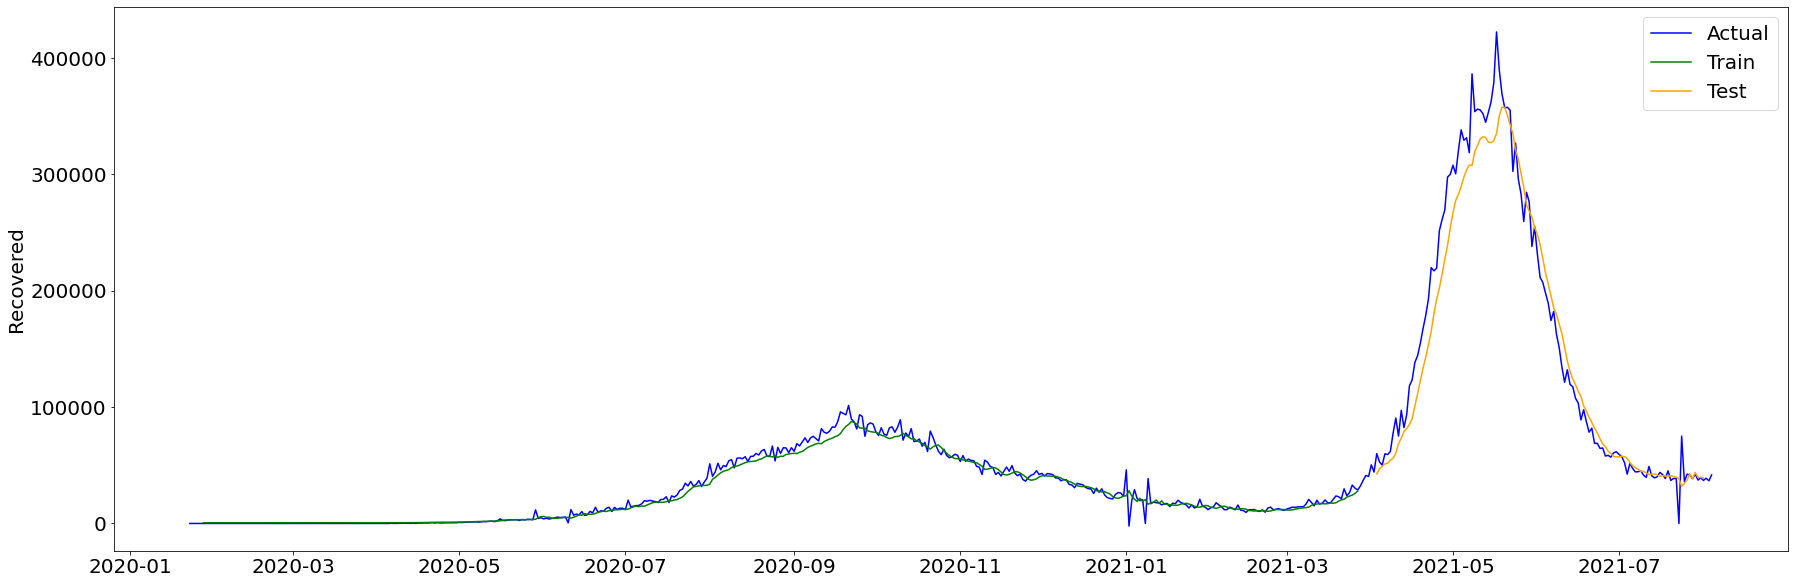

In [482]:
# similar approach for recovered cases
lag = 5
train, test = prepare_data(ts_recovered_diff1, lag, 0.77)

scalerTrain = MinMaxScaler()
train = scalerTrain.fit_transform(train.reshape(-1,1))

scalerTest = MinMaxScaler()
test = scalerTest.fit_transform(test.reshape(-1,1))

trainX, trainY = format_data(train, lag)
testX, testY = format_data(test, lag)

metricsRecoveredTrain = {"Model": "LSTM-Recovered", "Data": "Train"}
metricsRecoveredTest = {"Model": "LSTM-Recovered", "Data": "Test"}

modelRecovered = get_model(trainX, trainY, 20, 30,1, lag)
trainPredict = get_predictions(modelRecovered, trainX, scalerTrain)
testPredict = get_predictions(modelRecovered, testX, scalerTest)
trainY = scalerTrain.inverse_transform([trainY])
testY = scalerTest.inverse_transform([testY])

evaluate_results(trainY, trainPredict, "Train", metricsRecoveredTrain)
evaluate_results(testY, testPredict, "Test", metricsRecoveredTest)
tsTrainPred_R = rearrange_data(trainPredict[:,0], ts_recovered_diff1, lag, trainPredict[:,0].shape[0]+lag)
tsTestPred_R = rearrange_data(testPredict[:,0], ts_recovered_diff1, trainPredict[:,0].shape[0]+1+lag+lag, trainPredict[:,0].shape[0]+testPredict[:,0].shape[0]+lag+lag-1)

plot_result(ts_recovered_diff1,tsTrainPred_R,tsTestPred_R, "Recovered")

#### 4.3.3. Build model for death cases

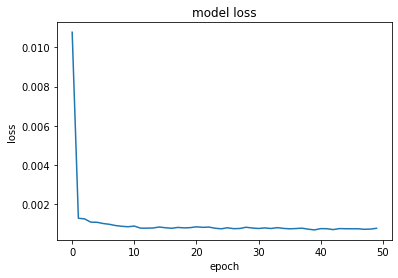

13/13 [==============================] - 0s 2ms/step
Train R2-score:  0.9818855589884863
Train Score: 120.08 RMSE
Train Score: 0.18 NRMSE
Test R2-score:  0.8694282004827932
Test Score: 83.89 RMSE
Test Score: 0.70 NRMSE


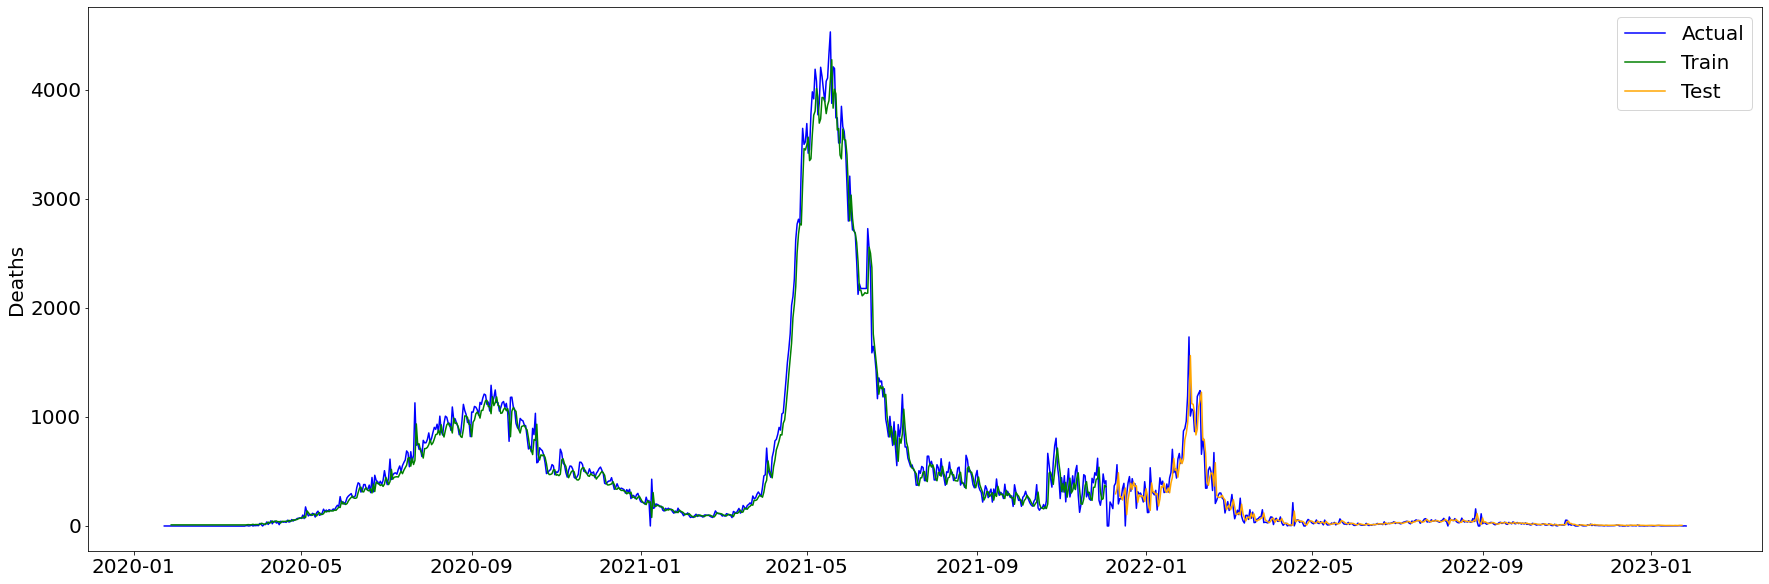

In [483]:
# similar approach for death cases
lag = 5
train, test = prepare_data(ts_deaths_diff1, lag, 0.62)

scalerTrain = MinMaxScaler()
train = scalerTrain.fit_transform(train.reshape(-1,1))

scalerTest = MinMaxScaler()
test = scalerTest.fit_transform(test.reshape(-1,1))

trainX, trainY = format_data(train, lag)
testX, testY = format_data(test, lag)

metricsDeathsTrain = {"Model": "LSTM-Deaths", "Data": "Train"}
metricsDeathsTest = {"Model": "LSTM-Deaths", "Data": "Test"}

modelDeaths = get_model(trainX, trainY, 20, 50,1, lag)
trainPredict = get_predictions(modelDeaths, trainX, scalerTrain)
testPredict = get_predictions(modelDeaths, testX, scalerTest)
trainY = scalerTrain.inverse_transform([trainY])
testY = scalerTest.inverse_transform([testY])
evaluate_results(trainY, trainPredict, "Train", metricsDeathsTrain)
evaluate_results(testY, testPredict, "Test", metricsDeathsTest)
tsTrainPred_D = rearrange_data(trainPredict[:,0], ts_deaths_diff1, lag, trainPredict[:,0].shape[0]+lag)
tsTestPred_D = rearrange_data(testPredict[:,0], ts_deaths_diff1, trainPredict[:,0].shape[0]+1+lag+lag, trainPredict[:,0].shape[0]+testPredict[:,0].shape[0]+lag+lag-1)

plot_result(ts_deaths_diff1,tsTrainPred_D,tsTestPred_D, "Deaths")

#### 4.4 Evaluate Models

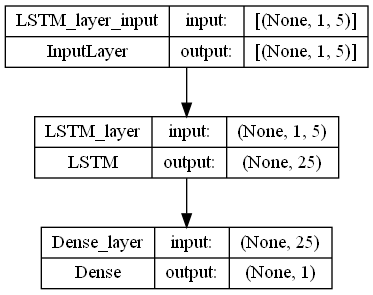

In [484]:
from tensorflow import keras

#plot the model for confirmed cases
keras.utils.plot_model(modelConfirmed, show_shapes= True, show_layer_names=True)

In [485]:
#compare metrics for different models
dfMetrics = pandas.DataFrame([metricsARIMATrain, metricsARIMATest, metricsConfirmedTrain, metricsConfirmedTest, metricsRecoveredTrain, metricsRecoveredTest ,metricsDeathsTrain, metricsDeathsTest])
dfMetrics

,Model,Data,R2Score,RMSE,NRMSE
0,ARIMA,Train,0.996004,4849.922185,0.095529
1,ARIMA,Test,0.987724,6839.634856,0.284159
2,LSTM-Confirmed,Train,0.992175,6766.296864,0.133920
3,LSTM-Confirmed,Test,0.986146,7406.457877,0.298992
4,LSTM-Recovered,Train,0.970672,4622.496081,0.173490
5,LSTM-Recovered,Test,0.957544,24609.628804,0.156322
6,LSTM-Deaths,Train,0.981886,120.075952,0.179555
7,LSTM-Deaths,Test,0.869428,83.890021,0.698391


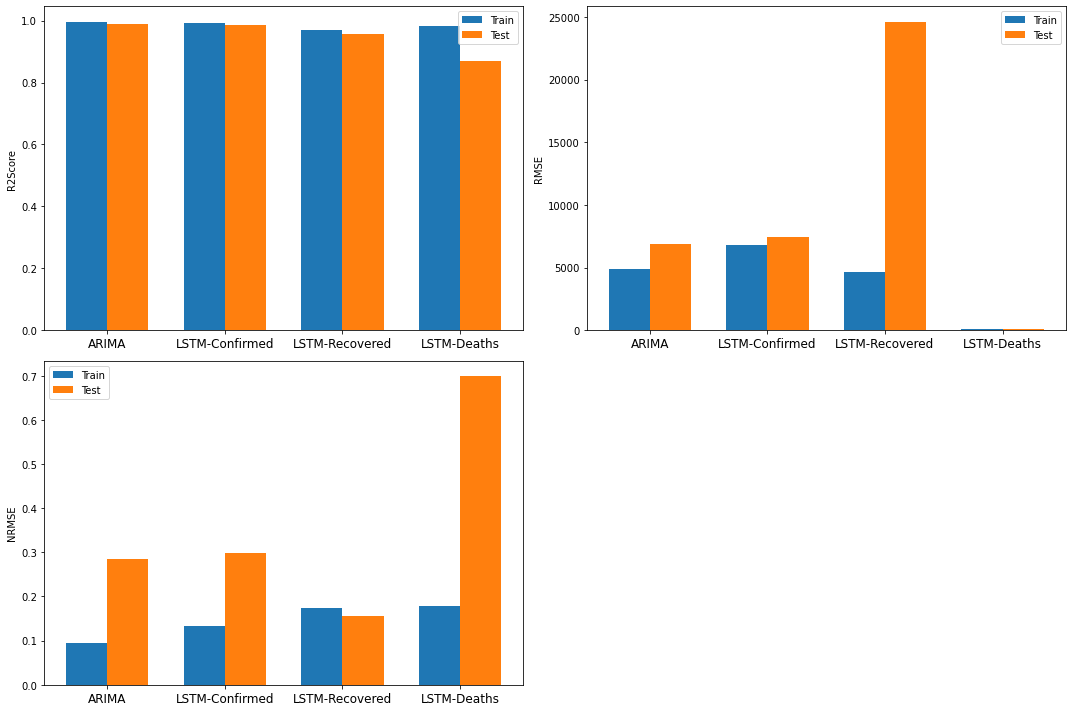

In [486]:
dfTest = dfMetrics[dfMetrics['Data']== "Test"]
dfTrain = dfMetrics[dfMetrics['Data']== "Train"]
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plot_metrics(axs[0,0], dfTrain["Model"], dfTrain, dfTest, "R2Score")
plot_metrics(axs[0,1], dfTrain["Model"], dfTrain, dfTest, "RMSE")
plot_metrics(axs[1,0], dfTrain["Model"], dfTrain, dfTest, "NRMSE")
axs[1,1].set_visible(False)
fig.tight_layout()

plt.show()

## Part-5: Make Predictions

#### 5.1 Import libraries

In [427]:
import datetime

#### 5.2 Define funtions

In [428]:
def forecast(model, test, lag, seq, scaler):
    test = test.dropna().values
    test = test.astype('float32').reshape(-1,1)
    test = scaler.fit_transform(test.reshape(-1,1))
    result = list()
    for i in range(seq):
        X, y = format_data(test, lag)
        ypredict = get_predictions(model, X, scaler)
        ylast = ypredict[-1]
        yresult = round(ylast[0])
        if yresult < 0:
            yresult = yresult * -1
        result.append(yresult)
        ylast = scaler.transform(ylast.reshape(-1,1))
        test = np.append(test,ylast).reshape(-1,1)
    return result

In [429]:
def get_future_dates(start, n):
    daterange = list()
    for i in range(n): 
        start += datetime.timedelta(days=1)
        daterange.append(start)
    return daterange

In [430]:
def get_mortality_rate(deaths,confirmed):
    mortality = list()
    for i in range(len(deaths)):
        mortality.append((deaths[i]/confirmed[i])*100)
    return mortality

In [431]:
def get_cumulative_data(startValue, ts):
    ts2 = list()
    for i in range(len(ts)):
        ts2.append(ts[i]+startValue)
        startValue = ts2[i]
    return ts2

#### 5.3 Make predictions using the models 

In [500]:
#make predictions for the next m days based on previous n days
n= 30
m= 7
lag = 5
testConfirmed = ts_confirmed_diff1[n*-1:]
scaler = StandardScaler()
resultConfirmed = forecast(modelConfirmed, testConfirmed, lag, m, scaler)
testDeaths = ts_deaths_diff1[n*-1:]
scaler = MinMaxScaler()
resultDeaths = forecast(modelDeaths, testDeaths, lag, m, scaler)
futureDates = get_future_dates(ts_confirmed_diff1.index[-1],m)
mortality = get_mortality_rate(resultDeaths,resultConfirmed)
dfForecast = pandas.DataFrame.from_dict({'Date': futureDates,'Confirmed': resultConfirmed,'Deaths': resultDeaths,'Recovered':np.repeat(['NA'],m),'Mortality%':mortality})
dfForecast = dfForecast.set_index('Date')
dfForecast

1/1 [==============================] - 0s 28ms/step


,Confirmed,Deaths,Recovered,Mortality%
Date,,,,
2023-01-27,114,1,NA,0.877193
2023-01-28,122,1,NA,0.819672
2023-01-29,115,0,NA,0.000000
2023-01-30,107,0,NA,0.000000
2023-01-31,102,1,NA,0.980392
2023-02-01,113,0,NA,0.000000
2023-02-02,97,0,NA,0.000000


<span style="color:teal">**We can see that the predictions look pretty good and are in line with actual number of cases**</span>

In [501]:
#get cumulative predicted values to match with original data
confirmed = get_cumulative_data(ts_confirmed[-1], resultConfirmed)
deaths = get_cumulative_data(ts_deaths[-1], resultDeaths)
dfForecast_Cumulative = pandas.DataFrame.from_dict({'Date': futureDates,'Confirmed(total)': confirmed,'Deaths(total)': deaths,'Recovered(total)':np.repeat(['NA'],m),'Mortality%':mortality})
dfForecast_Cumulative = dfForecast_Cumulative.set_index('Date')
dfForecast_Cumulative

,Confirmed(total),Deaths(total),Recovered(total),Mortality%
Date,,,,
2023-01-27,44682452,530739,NA,0.877193
2023-01-28,44682574,530740,NA,0.819672
2023-01-29,44682689,530740,NA,0.000000
2023-01-30,44682796,530740,NA,0.000000
2023-01-31,44682898,530741,NA,0.980392
2023-02-01,44683011,530741,NA,0.000000
2023-02-02,44683108,530741,NA,0.000000


<span style="color:teal">**- At this point we have successfully predicted the Confirmed cases, Death cases and Mortality rate.**</span>

<span style="color:teal">**- We are not able to predic the Recovered cases, the they have stopped reporting the Recovered cases after Aug-2021, but we have built and evaluated the model for recovered cases with the available data**</span>

## Part-6: Improving models

#### 6.1. Import Libraries

In [487]:
from tensorflow.keras.layers import Dropout

#### 6.2. Define functions

In [488]:
def get_improved_model(units, lag, layers, dropout, loss, optimizer, activation):
    # create and fit the improved LSTM network
    model = Sequential()
    model.add(LSTM(units = units, input_shape=(1, lag), return_sequences=True, name ="LSTM_layer_1"))
    for i in range(layers-1):
        if(i == layers-2):
            model.add(LSTM(units= units, name="LSTM_layer_"+str(i+2)))
        else:
            model.add(LSTM(units=units, return_sequences=True, name= "LSTM_layer_"+str(i+2)))
        model.add(Dropout(dropout, name ="Dropout_"+str(i+1)))     
    model.add(Dense(units = 1, activation = activation, name="Dense"))
    model.compile(loss=loss, optimizer=optimizer)
    return model

def fit_improved_model(model, trainX, trainY,  epochs, batchsize):
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=batchsize, verbose=0)
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    
def pipeline(lag,split, ts, params):
    train, test = prepare_data(ts, lag, split)

    scalerTrain = StandardScaler()
    train = scalerTrain.fit_transform(train.reshape(-1,1))

    scalerTest = StandardScaler()
    test = scalerTest.fit_transform(test.reshape(-1,1))

    trainX, trainY = format_data(train, lag)
    testX, testY = format_data(test, lag)
    metricsTrain = {"Model": "LSTM-improved", "Data": "Train"}
    metricsTest = {"Model": "LSTM-improved", "Data": "Test"}

    model = get_improved_model(params['units'],lag, params['layers'],params['dropout'], params['loss'], params['optimizer'], params['activation'])
    fit_improved_model(model,trainX,trainY,params['epocs'], params['batchsize'])
    #model = get_model(trainX, trainY, 20, 100,1, lag)
    trainPredict = get_predictions(model, trainX, scalerTrain)
    #print(trainPredict)
    testPredict = get_predictions(model, testX, scalerTest)
    trainY = scalerTrain.inverse_transform([trainY])
    testY = scalerTest.inverse_transform([testY])
    evaluate_results(trainY, trainPredict, "Train", metricsTrain)
    evaluate_results(testY, testPredict, "Test", metricsTest)
    tsTrainPred = rearrange_data(trainPredict[:,0], ts, lag, trainPredict[:,0].shape[0]+lag)
    tsTestPred = rearrange_data(testPredict[:,0], ts, trainPredict[:,0].shape[0]+1+lag+lag, trainPredict[:,0].shape[0]+testPredict[:,0].shape[0]+lag+lag-1)

    plot_result(ts,tsTrainPred,tsTestPred, "Result")
    return model, metricsTrain, metricsTest

#### 6.3. Build improved model for confirmed cases

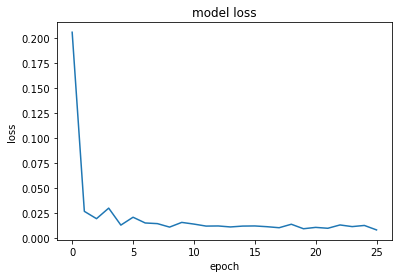

13/13 [==============================] - 0s 3ms/step
Train R2-score:  0.9949930625311433
Train Score: 5418.96 RMSE
Train Score: 0.11 NRMSE
Test R2-score:  0.9879685308506096
Test Score: 6925.85 RMSE
Test Score: 0.28 NRMSE


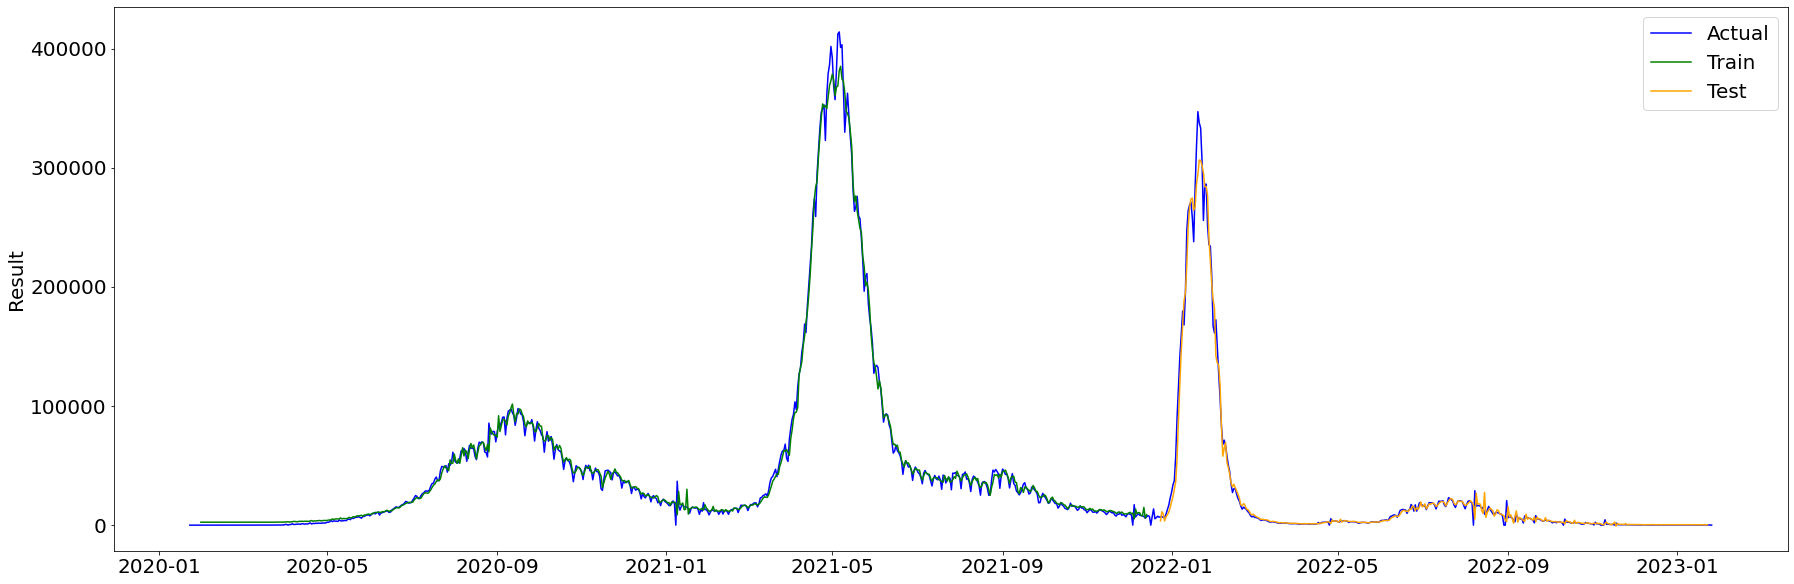

In [489]:
params = {
    "units" : 64,
    "layers" : 2,
    "dropout" : 0.0,
    "loss" : "mean_squared_error",
    "optimizer" : "adam",
    "activation" : "linear",
    "epocs" : 26,
    "batchsize" : 1
}
model, metricsTrain, metricsTest = pipeline(8,0.63,ts_confirmed_diff1, params)


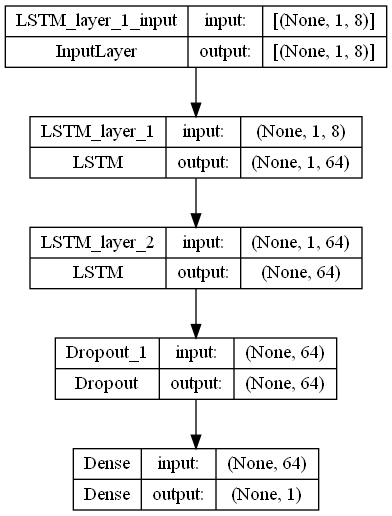

In [490]:
keras.utils.plot_model(model, show_shapes= True, show_layer_names=True)

In [491]:
dfMetricsConfirmed = pandas.DataFrame([metricsARIMATrain, metricsARIMATest, metricsConfirmedTrain, metricsConfirmedTest, metricsTrain, metricsTest])
dfMetricsConfirmed

,Model,Data,R2Score,RMSE,NRMSE
0,ARIMA,Train,0.996004,4849.922185,0.095529
1,ARIMA,Test,0.987724,6839.634856,0.284159
2,LSTM-Confirmed,Train,0.992175,6766.296864,0.133920
3,LSTM-Confirmed,Test,0.986146,7406.457877,0.298992
4,LSTM-improved,Train,0.994993,5418.961089,0.106785
5,LSTM-improved,Test,0.987969,6925.854189,0.278072


<span style="color:teal">**We can see that all three metrics R2Score, RMSE and NRMSE have improved after improvement to model**</span>

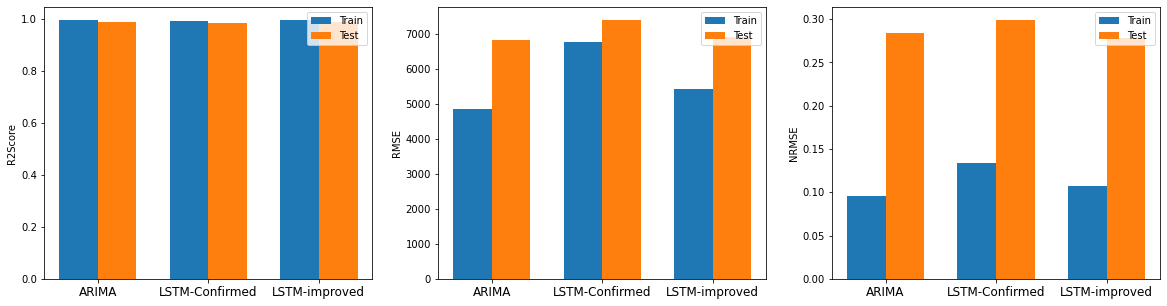

In [492]:
dfTest = dfMetricsConfirmed[dfMetricsConfirmed['Data']== "Test"]
dfTrain = dfMetricsConfirmed[dfMetricsConfirmed['Data']== "Train"]
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
plot_metrics(axs[0], dfTrain["Model"], dfTrain, dfTest, "R2Score")
plot_metrics(axs[1], dfTrain["Model"], dfTrain, dfTest, "RMSE")
plot_metrics(axs[2], dfTrain["Model"], dfTrain, dfTest, "NRMSE")

<span style="color:teal">**We can see that adding more layers and increasing number of units slightly improves the performace of the LSTM model**</span>

### Summary:

**In this project we have done following things:** 

**1. Imported the data from the github http links and formatted it to create 3 timeseries for confirmed, recovered and death cases**

**2. Established that the given series are non-stationary using Augmented Dickey Fuller test and applied differencing and formatting to them**

**3. Derived the mortality rate from the confirmed cases and death cases time series**

**4. Plotted the acf and pacf plots for confirmed cases to determine the p,d,q values for ARIMA model**

**5. Built the ARIMA model for confirmed cases and calcualted metrics: Root mean squared error, Normalized root mean squared error and R2-score**

**6. Plotted the residual errors for the ARIMA results and ARIMA result summary**

**7. Divided the series into training and test data and used scalers to scale the data values**

**8. Built 3 different LSTM models for Confirmed cases, Recovered cases and Death cases, plotted their loss curves and test results for predicted training and test data with respect to the actual data**

**9. Evaluated the 3 models by comparing metrics Root mean squared error, Normalized root mean squared error and R2-score**

**10. Predicted the values for next 7 days based on last 30 days data using the previously trained models**

**11. Built improved LSTM model for confirmed cases by using optimization techniques like hyper-parameter tuning, dropout and early stopping**


### Conclusion:

In this project we have used 2 different modeling techniques for timeseries prediction. While ARIMA is also a good model for timeseries prediction for a smaller dataset like this one, it tends to overfit the data and there are less ways to optimize the model. LSTM on the other hand is more robust and can be optimized in many ways. 
Before building the models, it is important that the timeseries is stationary. If not, there are techniques to make it stationary. The scale of the given data is also very large, it varies from 0-4,00,000. Hence it is important to scale the data before fitting the models. The metrics also need to be normalised due to such variation in the data scale. Currently we have used the entire data for country India. Going ahead the code can be modularized and generalized to predict values for any country and from any time period.